In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import missingno as mso
import datetime as datetime
import calendar

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import KFold , RandomizedSearchCV,train_test_split,GridSearchCV

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import accuracy_score, roc_auc_score , precision_score, recall_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection

from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score

In [2]:
file1 = "/Users/1535/OneDrive - Xceedance Consulting India Private Ltd/Gazal Xceedance/EDV/Python/Python Projects/Project 2/carvan_train.csv"
carvan_train=pd.read_csv(file1)

file2 = "/Users/1535/OneDrive - Xceedance Consulting India Private Ltd/Gazal Xceedance/EDV/Python/Python Projects/Project 2/carvan_test.csv"
carvan_test=pd.read_csv(file2)

In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(carvan_train.shape))
print("The test data size before dropping Id feature is : {} ".format(carvan_test.shape))

The train data size before dropping Id feature is : (5822, 86) 
The test data size before dropping Id feature is : (4000, 85) 


Class 0: 5474
Class 1: 348
Proportion: 15.73 : 1


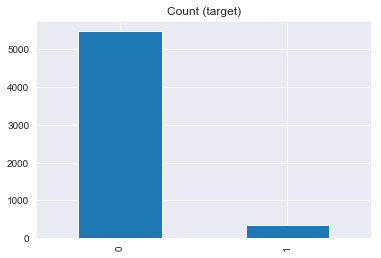

In [4]:
target_count = carvan_train['V86'].value_counts()

print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [5]:
carvan_train['data'] = 'Train'
carvan_test['data'] = 'Test'
carvan_test['V86'] = np.nan

In [6]:
carvan_test=carvan_test[carvan_train.columns] # the columns in the two data frames should be in the same order to enable concatenation
#validation_set=validation_set[carvan_train_over.columns]
carvan=pd.concat([carvan_train,carvan_test],axis=0)
carvan = carvan.reset_index()

In [7]:
del carvan['index']
carvan.shape

(9822, 87)

In [8]:
carvan.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V78,V79,V80,V81,V82,V83,V84,V85,V86,data
0,33,1,3,2,8,0,5,1,3,7,...,0,0,1,0,0,0,0,0,0.0,Train
1,37,1,2,2,8,1,4,1,4,6,...,0,0,1,0,0,0,0,0,0.0,Train
2,37,1,2,2,8,0,4,2,4,3,...,0,0,1,0,0,0,0,0,0.0,Train
3,9,1,3,3,3,2,3,2,4,5,...,0,0,1,0,0,0,0,0,0.0,Train
4,40,1,4,2,10,1,4,1,4,7,...,0,0,1,0,0,0,0,0,0.0,Train


In [9]:
carvan.data.value_counts()

Train    5822
Test     4000
Name: data, dtype: int64

Thought the data looks numeric but the features are categorical in nature. As per the data disctionary this has been interpreted. Now coverting into Dummies

V1 can be dropped , V4num, V5 need to be dropped, V6num

New to create - V1	V5	V6	V7	V8	V9	V10	V11	V12	V13	V14	V15	V16	V17	V18	V19	V20	V21	V22	V23	V24	V25	V26	V27	V28	V29	V30	V31	V32	V33	V34	V35	V36	
V37	V38	V39	V40	V41	V42	V43 - almost 0 impact

In [9]:
cat_cols = ["V1","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19",
            "V20","V21","V22","V23","V24","V25","V26","V27","V28","V29","V30","V31","V32","V33","V34","V35",
            "V36"]

In [10]:
for c in cat_cols:
    carvan[c]=carvan[c].astype(str)

In [11]:
#not in use
#carvan["V1"] = carvan["V1"].astype(str)

#carvan["V5"] = carvan["V5"].astype(str)

In [12]:
for c in cat_cols:
    print(carvan[c].dtypes)

object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object


In [13]:
for col in cat_cols:
    freqs=carvan[col].value_counts()
    selected_cats=freqs.index[freqs>100][:-1]
    
    print(col)
    for cat in selected_cats:
        name=col+'_'+cat
        
        carvan[name]=(carvan[col]==cat).astype(int)
    del carvan[col]

V1
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36


In [14]:
for col in carvan.select_dtypes(['object']).columns:
    print(col,':',carvan[col].nunique())

data : 2


In [15]:
carvan.shape

(9822, 297)

In [16]:
carvan_train = carvan[carvan['data'] == 'Train']
carvan_test = carvan[carvan['data']=='Test']
del carvan_train['data']
del carvan_test['data']
del carvan_test['V86']

In [17]:
X = carvan_train.drop(['V86'],1)
Y = carvan_train['V86']

In [18]:
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.20,random_state = 42,stratify= Y)

Trying with Random Forest to check the inital feasibilyt and Feature importance

In [26]:
rf_model  = RandomForestClassifier()
rf_model.fit(x_train, y_train)

predicted = rf_model.predict(x_test)

print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print(confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score is : 0.9296137339055794
Recall Score is : 0.05714285714285714
Precision Score is : 0.2
Auc Score is :  0.5212654924983692
Fbeta 2 Score is : 0.5419970631424376
[[1079   16]
 [  66    4]]


Feature ranking:
1. feature V2 (0.054775)
2. feature V3 (0.048951)
3. feature V4 (0.044541)
4. feature V44 (0.028800)
5. feature V45 (0.027271)
6. feature V46 (0.021898)
7. feature V47 (0.012791)
8. feature V48 (0.012277)
9. feature V49 (0.011056)
10. feature V50 (0.010816)
11. feature V51 (0.010159)
12. feature V52 (0.007732)
13. feature V53 (0.007272)
14. feature V54 (0.006884)
15. feature V55 (0.006651)
16. feature V56 (0.006248)
17. feature V57 (0.005883)
18. feature V58 (0.005874)
19. feature V59 (0.005838)
20. feature V60 (0.005750)
21. feature V61 (0.005704)
22. feature V62 (0.005405)
23. feature V63 (0.005387)
24. feature V64 (0.005203)
25. feature V65 (0.005168)
26. feature V66 (0.005146)
27. feature V67 (0.005047)
28. feature V68 (0.005012)
29. feature V69 (0.004931)
30. feature V70 (0.004842)
31. feature V71 (0.004823)
32. feature V72 (0.004758)
33. feature V73 (0.004753)
34. feature V74 (0.004732)
35. feature V75 (0.004719)
36. feature V76 (0.004669)
37. feature V77 (0.0045

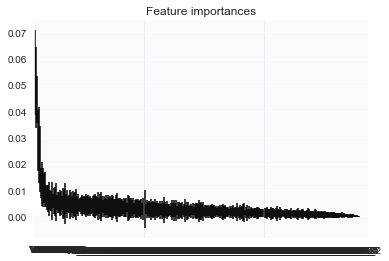

In [27]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), list(x_train.columns))
plt.xlim([-1, x_train.shape[1]])
plt.show()

Trying with XG Boost Algorithm

In [28]:
XG_clf=XGBClassifier(objective='binary:logistic')
XG_clf.fit(x_train,y_train)
predicted = XG_clf.predict(x_test)

print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print('Fbeta 2 Score is :', confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

Accuracy Score is : 0.9399141630901288
Recall Score is : 0.0
Precision Score is : 0.0
Auc Score is :  0.5
Fbeta 2 Score is : 0.4756733275412684
Fbeta 2 Score is : [[1095    0]
 [  70    0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


XG Boost with Parameter tunning

In [30]:
XG_clf1=XGBClassifier(objective='binary:logistic')

In [ ]:
xgb_params = {  
                "learning_rate":[0.01,0.05,0.1,0.3,0.5],
                "gamma":[i/10.0 for i in range(0,5)],
                "max_depth": [2,3,4,5,6,7,8],
                "min_child_weight":[1,2,5,10],
                "max_delta_step":[0,1,2,5,10],
                "subsample":[i/10.0 for i in range(5,10)],
                "colsample_bytree":[i/10.0 for i in range(5,10)],
                "colsample_bylevel":[i/10.0 for i in range(5,10)],
                "reg_lambda":[1e-5, 1e-2, 0.1, 1, 100], 
                "reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
                "scale_pos_weight":[1,2,3,4,5],
                "n_estimators":[100,500,700,1000]
             }

n_iter=10

random_search=RandomizedSearchCV(XG_clf1,n_jobs=-1,verbose=3,cv=5,n_iter=n_iter,scoring='roc_auc',
                                 param_distributions=xgb_params)

random_search.fit(x_train,y_train)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_,5)

random_search.best_estimator_

In [29]:
#after best parameter is learnt
xgb_best=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
       learning_rate=0.01, max_delta_step=1, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=100, scale_pos_weight=5, seed=None,
       silent=None, subsample=0.5, verbosity=1)

In [30]:
xgb_best.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0.1,
       learning_rate=0.01, max_delta_step=1, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=100, scale_pos_weight=5, seed=None,
       silent=None, subsample=0.5, verbosity=1)

In [31]:
predicted = xgb_best.predict(x_test)

print('Accuracy Score is :' , accuracy_score(y_test,predicted))
print('Recall Score is :',recall_score(y_test,predicted))
print('Precision Score is :',precision_score(y_test,predicted))
print('Auc Score is : ', roc_auc_score(y_test,predicted))
print('Fbeta 2 Score is :', fbeta_score(predicted,y_test, average='macro', beta=2))
print('Confusion Matrix :', confusion_matrix(y_test, predicted, labels=None, sample_weight=None))

Accuracy Score is : 0.9175965665236051
Recall Score is : 0.2
Precision Score is : 0.25925925925925924
Auc Score is :  0.5817351598173516
Fbeta 2 Score is : 0.5985466059486642
Confusion Matrix : [[1055   40]
 [  56   14]]


Finding out the correct probabilty cutoff to predict hard classess

In [52]:
cutoffs=np.linspace(0.01,0.99,99)
cutoffs

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [53]:
train_score=xgb_best.predict_proba(x_train)[:,1] # the predicted response variable values
real=y_train # the actual response variable values
print(xgb_best.classes_) # In order to find the probability of which column is for outcome 1 and which for outcome 0

[0. 1.]


In [54]:
KS_all=[]
for cutoff in cutoffs:
    predicted=(train_score>cutoff).astype(int)
    
    TP=((predicted==1) & (real==1)).sum()
    TN=((predicted==0) & (real==0)).sum()
    FP=((predicted==1) & (real==0)).sum()
    FN=((predicted==0) & (real==1)).sum()
    
    P=TP+FN
    N=TN+FP
    KS=(TP/P)-(FP/N)
    KS_all.append(KS)
    
# try out what cutoffs you get when you use F_beta scores with different values of betas [0.5 , 5]
# beta < 1 : you will get cutoff , which is high ( favours precision)
# beta > 1 : you will get cutoff , which is low (favours precision )

In [55]:
list(zip(cutoffs,KS_all))

[(0.01, 0.0),
 (0.02, 0.0),
 (0.03, 0.0013701758392327124),
 (0.04, 0.019410824389129888),
 (0.05, 0.06828042932176293),
 (0.060000000000000005, 0.1356474080840374),
 (0.06999999999999999, 0.2068965517241379),
 (0.08, 0.27083809088833066),
 (0.09, 0.3274720255766157),
 (0.09999999999999999, 0.3709742870239091),
 (0.11, 0.4116795168569415),
 (0.12, 0.44918766973176427),
 (0.13, 0.4832703830085053),
 (0.14, 0.5142126992628323),
 (0.15000000000000002, 0.53876086160074),
 (0.16, 0.5614254428838752),
 (0.17, 0.5816913950000082),
 (0.18000000000000002, 0.6065829227460688),
 (0.19, 0.6222816220647598),
 (0.2, 0.6298159462838498),
 (0.21000000000000002, 0.6490550879689032),
 (0.22, 0.6596731292746119),
 (0.23, 0.6597281663137177),
 (0.24000000000000002, 0.6577279395939745),
 (0.25, 0.6557277128742313),
 (0.26, 0.6600082801993162),
 (0.27, 0.6397373993931139),
 (0.28, 0.638537263361268),
 (0.29000000000000004, 0.6351101808664966),
 (0.3, 0.6386489803361695),
 (0.31, 0.6331666340825489),
 (0.32,

In [56]:
mycutoff=cutoffs[KS_all==max(KS_all)][0]
mycutoff # gives the cutoff value where KS is maximum

0.26

In [57]:
test_score=xgb_best.predict_proba(carvan_test)[:,1]
test_score

array([0.09644467, 0.6104807 , 0.3723423 , ..., 0.32952014, 0.3532237 ,
       0.20372385], dtype=float32)

In [58]:
test_classes=(test_score>mycutoff).astype(int)
print(test_classes)

[0 1 1 ... 1 1 0]


In [59]:
sum(test_classes)

884

In [60]:
pd.DataFrame(test_classes).to_csv("Project2_Part2_0.2.csv",index=False)
# Please give the file a proper name before submission